# Lizenz

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Wichtige Infos

Damit die beiden Notebook funktionieren und Daten untereinander austauschen können, sollte die Google Drive Verknüpfung in Google Colab aktivert werden. Sollten die Notebooks auf einer Lokalen Instanz ausgeführt werden, so sind die relativen Pfade für den Austausch zu nutzen.

In diesem Notebook werden die Sensordaten von NodeRed via HTTP importiert. Sollte dies nicht möglich sein, so kann ganz unten eine Funktion gefunden werden, welche einen CSV String als Datei in der Google Drive ablegt und so dann importiert werden kann. Beim Import der Sensordaten dann die richtige Methode des Imports auswählen.

Das Notebook ist eine angepasste Version des "Time series forecasting" des Tensorflow beispiels, welches [hier](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb) gefunden werden kann. Die Lizenz des Beispiels ist dabei die "Apache License, Version 2.0".

# Setup

Benötigte Pakete importieren

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

import requests
import io

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = True

# Import des Dataset
Datensatz importieren

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


# Umwandlung des Intervalls
Umwandlung des 10 Minuten Intervall duch verwerfen der Werte in 1 Stunden Intervall

In [ ]:
df = pd.read_csv(csv_path)

# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Übersicht über Daten

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Graphen von Temperatur, Druck und Luftdichte

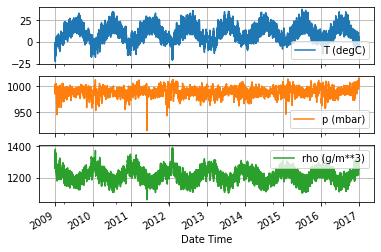

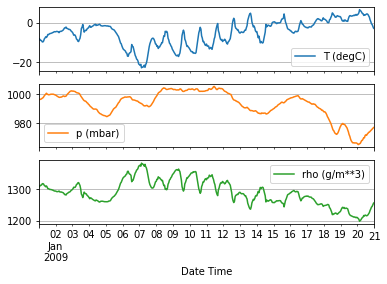

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Übersicht der im Datensatz enthaltenen Daten

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# Data cleanup
Invalide Daten aus dem Datenset entfernen

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

# Feature Engineering
genauere Infos über die Vorverarbeitung der Daten [hier](https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering)

## Wind
Winddaten in Windvektor umrechnen

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

## Zeit
Zeitdaten in Cosinus- und Sinusdaten umwandeln, um dem Algorithmus die Periodizität der Daten aufzuzeigen

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

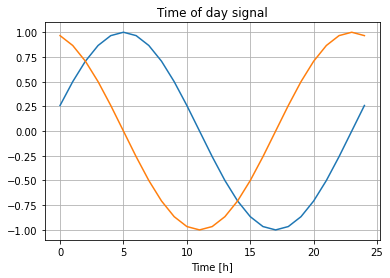

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

# Datensplit
Daten in 70% Trainingsdaten, 20% Validierungsdaten und 10% Testdaten unterteilen. Dies passiert nicht zufällig, die Reihnfolge der Daten wird beibehalten!

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Normalisierung der Daten
Normalisierung aller Features auf einen ähnlichen Werteberreich

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

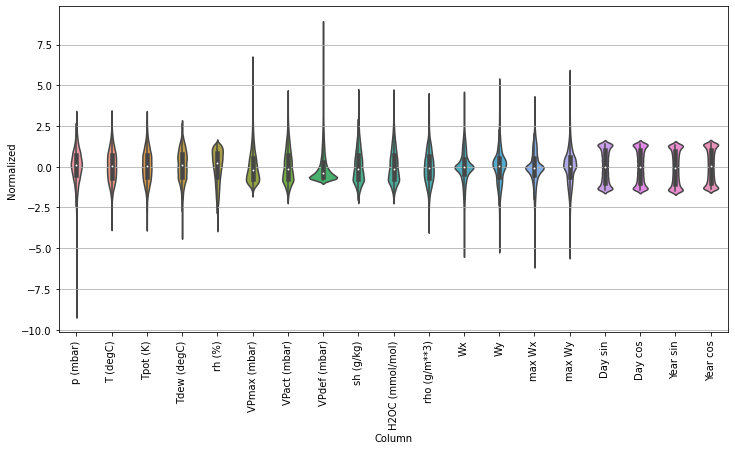

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Einteilung der Daten ("Data Windowing")

## Indexes/Offset

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.own_data = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Split

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Plot

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3, usePredictionData=False, denormalise=False, minY=None, maxY=None, lastHours=None):

  if usePredictionData:
    inputs_raw, labels_raw = self.predictionData
  else:
    inputs_raw, labels_raw = self.example
  

  labelLen = len(labels_raw[0, :])
  labelStartIndex = 0
  labelStopIndex = labelLen
  temp_label_indices = self.label_indices

  inputLen = len(inputs_raw[0, :])
  inputStartIndex = 0
  inputStopIndex = inputLen
  temp_input_indices = self.input_indices

  if lastHours is not None:
    labelStartIndex = labelLen - lastHours
    temp_labelStartIndex = len(temp_label_indices)-lastHours
    temp_label_indices = temp_label_indices[temp_labelStartIndex:]

    inputStartIndex = inputLen - lastHours - (inputLen-labelLen)
    temp_inputStartIndex = len(temp_input_indices)-lastHours - (inputLen-labelLen)
    temp_input_indices = temp_input_indices[temp_inputStartIndex:]


  if denormalise:
    inputs = (inputs_raw * train_std["T (degC)"]) + train_mean["T (degC)"]
    labels = (labels_raw * train_std["T (degC)"]) + train_mean["T (degC)"]
  else:
    inputs = inputs_raw
    labels = labels_raw
  
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')

    if minY != None and maxY != None:
      ax = plt.gca()
      ax.set_ylim([minY, maxY])

    plt.plot(temp_input_indices, inputs[n, inputStartIndex:inputStopIndex, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(temp_label_indices, labels[n, labelStartIndex:labelStopIndex, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None:
      predictions = model(inputs_raw)
      if denormalise:
        predictions = (predictions * train_std["T (degC)"]) + train_mean["T (degC)"]
      
      plt.scatter(temp_label_indices, predictions[n, labelStartIndex:labelStopIndex, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## Konvertieren zum Dataset

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def predictionData(self):
  return next(iter(self.make_dataset(self.own_data)))

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.predictionData = predictionData

## Funktion zum hinzufügen eigener Daten

In [ ]:
def addDataFrame(self, own_df=None):
  self.own_data = own_df

WindowGenerator.addDataFrame = addDataFrame

# Training der Algorithmen - Single Step

## Setup

Definition der Trainingsdatensätze

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [ ]:
CONV_WIDTH = 5

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['T (degC)']

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Label column name(s): ['T (degC)']

## Baseline

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

# start des "Trainings"
baseline_time_start = datetime.datetime.now()

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

baseline_time_end = datetime.datetime.now()

val_performance = {}
performance = {}
performance_time = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
performance_time['Baseline'] = (baseline_time_end - baseline_time_start).total_seconds()

439/439 [==============================] - 3s 6ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


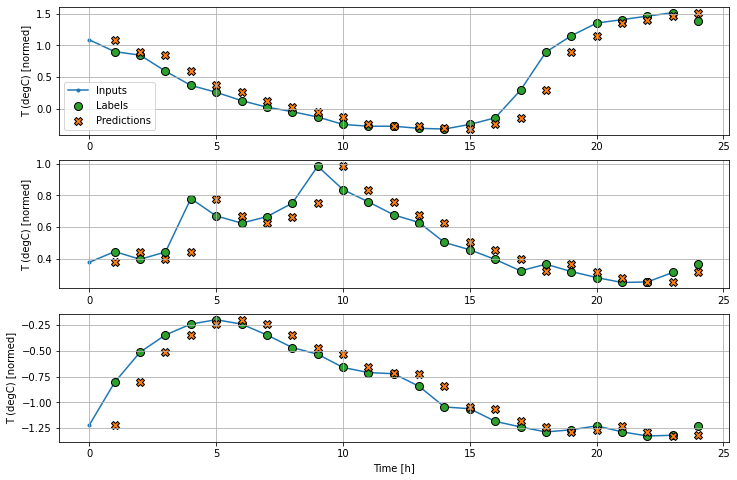

In [ ]:
# Ausgabe von Beispielplots auf "bekannte" Trainingsdaten - in diesem Fall wird jedoch nur der vorherige Wert wiederholt
wide_window.plot(baseline)

## Linear

In [ ]:
# Definition des Netzwerks
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

def compile(model, window, patience=2):
  arly_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  return history

In [ ]:
# start des Trainings
linear_time_start = datetime.datetime.now()

history = compile_and_fit(linear, single_step_window)

linear_time_end = datetime.datetime.now() 


val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
performance_time['Linear'] = (linear_time_end - linear_time_start).total_seconds()

Epoch 1/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.1091 - mean_absolute_error: 0.2048 - val_loss: 0.0143 - val_mean_absolute_error: 0.0870
Epoch 2/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0797 - val_loss: 0.0103 - val_mean_absolute_error: 0.0755
Epoch 3/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0752 - val_loss: 0.0096 - val_mean_absolute_error: 0.0727
Epoch 4/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0732 - val_loss: 0.0094 - val_mean_absolute_error: 0.0716
Epoch 5/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0719 - val_loss: 0.0091 - val_mean_absolute_error: 0.0707
Epoch 6/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0713 - val_loss: 0.0089 - val_mean_absolute_error: 0.0695
Epoc

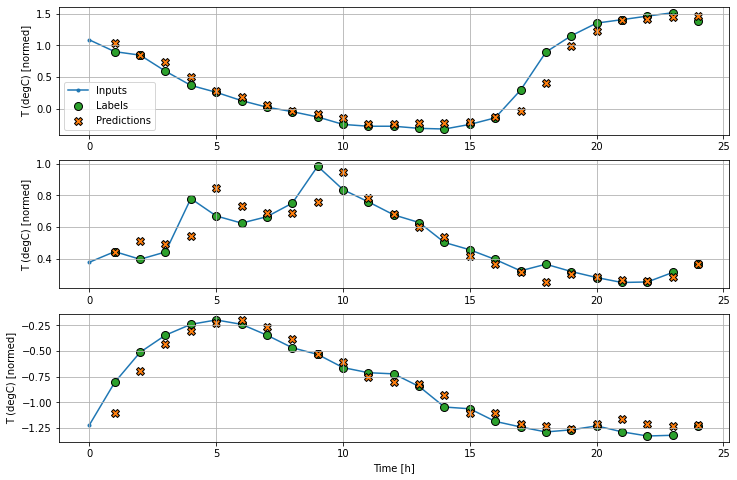

In [ ]:
# Ausgabe von Beispielplots auf bekannte Trainingsdaten
wide_window.plot(linear)

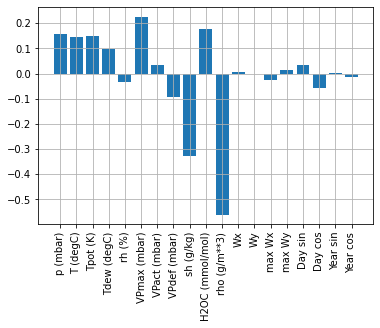

In [ ]:
# Ausgabe der Gewichte jedes Features für das lineare Netzwerk
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

In [ ]:
# Definition des Netzwerks
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# start des Trainings
dense_time_start = datetime.datetime.now()

history = compile_and_fit(dense, single_step_window)

dense_time_end = datetime.datetime.now()

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
performance_time['Dense'] = (dense_time_end - dense_time_start).total_seconds()

Epoch 1/20
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0136 - mean_absolute_error: 0.0776 - val_loss: 0.0086 - val_mean_absolute_error: 0.0665
Epoch 2/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0645 - val_loss: 0.0082 - val_mean_absolute_error: 0.0676
Epoch 3/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0075 - mean_absolute_error: 0.0625 - val_loss: 0.0077 - val_mean_absolute_error: 0.0632
Epoch 4/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0067 - val_mean_absolute_error: 0.0576
Epoch 5/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0070 - mean_absolute_error: 0.0596 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567
Epoch 6/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0069 - mean_absolute_error: 0.0588 - val_loss: 0.0066 - val_mean_absolute_error: 0.0565
E

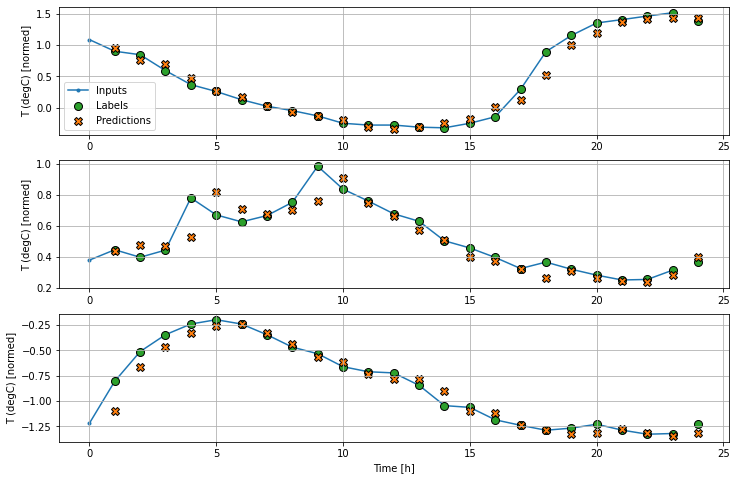

In [ ]:
# Ausgabe von Beispielplots auf bekannte Trainingsdaten
wide_window.plot(dense)

## Multi-Step Dense

Text(0.5, 1.0, 'Given 5 hours of inputs, predict 1 hour into the future.')

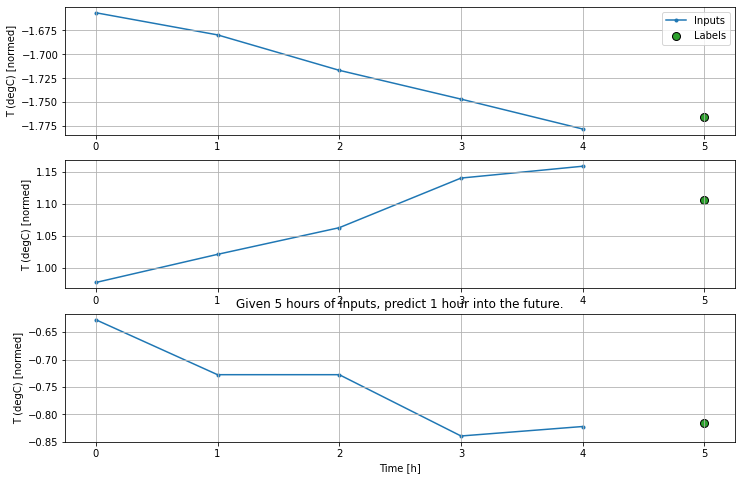

In [ ]:
conv_window.plot()
plt.title("Given " + str(CONV_WIDTH) + " hours of inputs, predict 1 hour into the future.")

In [ ]:
# Definition des Netzwerks
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
# start des Trainings
multi_step_dense_time_start = datetime.datetime.now()

history = compile_and_fit(multi_step_dense, conv_window)

multi_step_dense_time_end = datetime.datetime.now()

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
performance_time['Multi step dense'] = (multi_step_dense_time_end - multi_step_dense_time_start).total_seconds()

438/438 [==============================] - 2s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0720


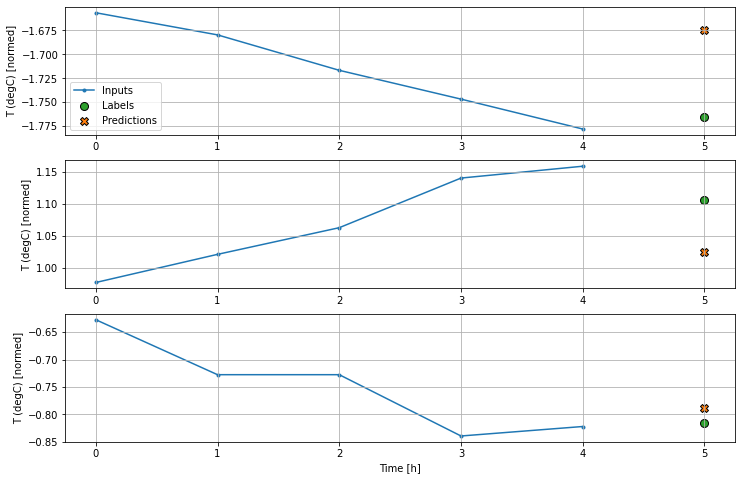

In [ ]:
# Ausgabe von Beispielplots auf bekannte Trainingsdaten
conv_window.plot(multi_step_dense)

## CNN

In [ ]:
# Definition des Netzwerks
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH-4,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
# start des Trainings
conv_time_start = datetime.datetime.now()

history = compile_and_fit(conv_model, conv_window)

conv_time_end = datetime.datetime.now()

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
performance_time['Conv'] = (conv_time_end - conv_time_start).total_seconds()

438/438 [==============================] - 2s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0559


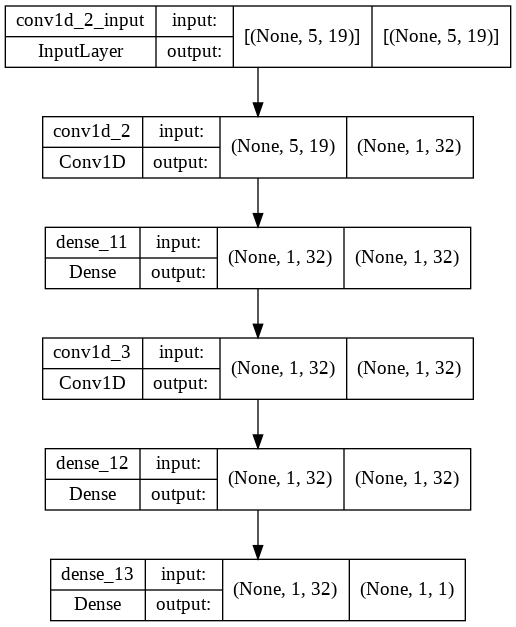

In [ ]:
# Ausgabe des Aufbaus des Netzwerkes (Aufbau der einzelnen Layer mit Inputs und Outputs)
plot_model(conv_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

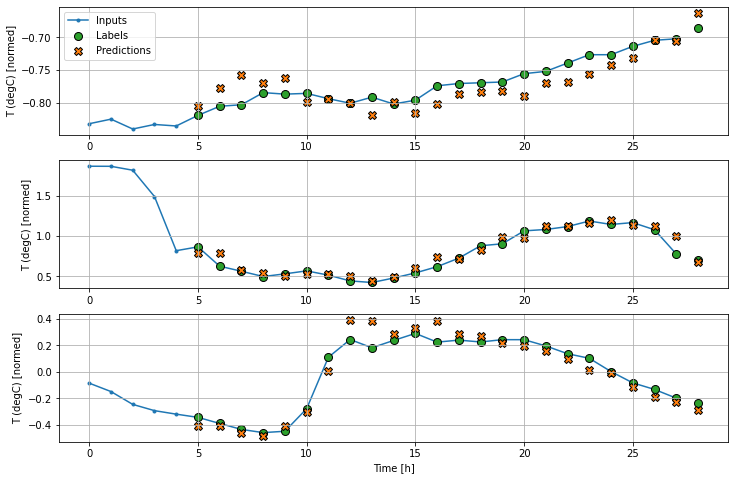

In [ ]:
# Ausgabe von Beispielplots auf bekannte Trainingsdaten
wide_conv_window.plot(conv_model)

## RNN

In [ ]:
# Definition des Netzwerks
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# start des Trainings
rnn_time_start = datetime.datetime.now()

history = compile_and_fit(lstm_model, wide_window)

rnn_time_end = datetime.datetime.now()

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
performance_time['LSTM'] = (rnn_time_end - rnn_time_start).total_seconds()

438/438 [==============================] - 4s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0521


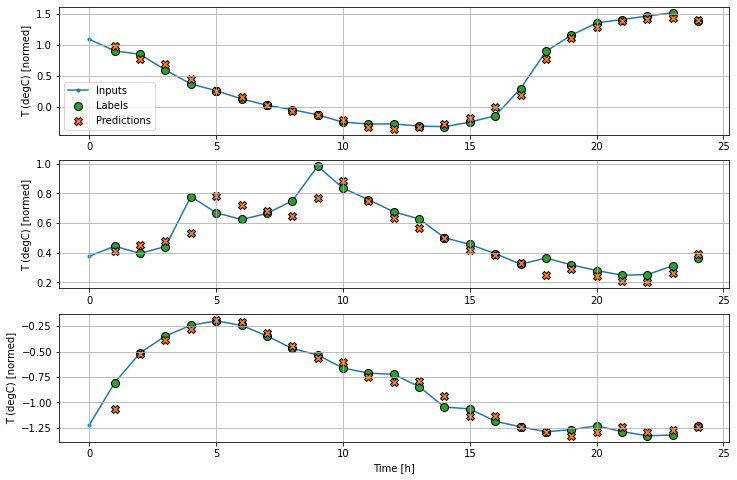

In [ ]:
# Ausgabe von Beispielplots auf bekannte Trainingsdaten
wide_window.plot(lstm_model)

# Performance der Algorithmen

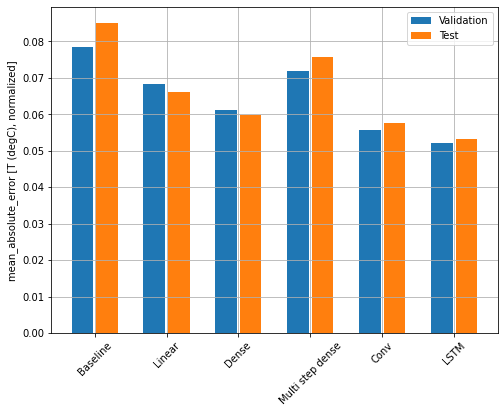

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0662
Dense       : 0.0600
Multi step dense: 0.0759
Conv        : 0.0577
LSTM        : 0.0532


# Zeit des Trainings der Algorithmen

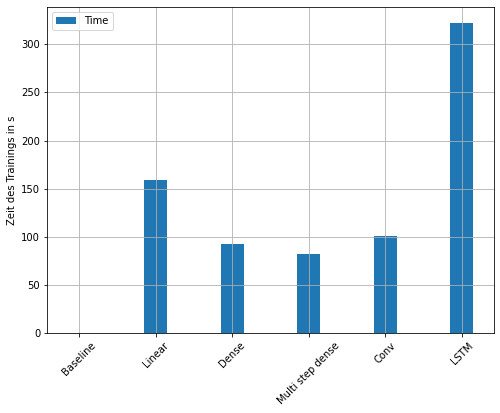

In [ ]:
# plot time for all algorithms

x = np.arange(len(performance_time))
width = 0.3

val_mae = [v for v in performance_time.values()]

plt.ylabel('Zeit des Trainings in s')
plt.bar(x, val_mae, width, label='Time')
plt.xticks(ticks=x, labels=performance_time.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance_time.items():
  print(f'{name:12s}: {value:0.4f}s')

Baseline    : 0.0190s
Linear      : 159.2847s
Dense       : 92.3640s
Multi step dense: 82.6208s
Conv        : 100.4968s
LSTM        : 322.3661s


# Vorhersage der Lokalen Temperatur

## Import der Messdaten des ESP8266 von NodeRed

### Via HTTP

In [ ]:
###
# Import via HTTP from Nodered
###

url = 'https://nodered.hydrogen.bonn/getCSVWeather.csv'

x = requests.get(url=url, verify=False).content 
mytext = "\n".join(x.decode('utf8').split("<br>"))

ownDf = pd.read_csv(io.StringIO(mytext))

ownDf.describe().transpose()

### Via CSV

In [ ]:
ownDf = pd.read_csv("/content/drive/MyDrive/Projekt III/owndata.csv")

ownDf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),106.0,1012.803585,7.684251,997.460000,1009.925000,1013.880000,1019.775000,1022.060000
T (degC),106.0,8.452896,4.965857,1.810864,4.481194,6.721343,11.223778,24.874500
Tpot (K),106.0,280.558853,4.897245,273.396563,276.288476,279.802700,282.952201,297.170492
Tdew (degC),106.0,0.485660,1.452608,-2.100000,-0.665000,0.510000,1.360000,5.000000
rh (%),106.0,61.570444,17.916760,0.000000,46.561765,64.415195,76.564305,93.100000
VPmax (mbar),106.0,11.665189,4.544670,6.960000,8.192500,10.440000,13.322500,31.460000
VPact (mbar),106.0,6.362547,0.691599,5.240000,5.825000,6.345000,6.740000,8.720000
VPdef (mbar),106.0,5.302642,4.285763,0.510000,2.287500,4.225000,7.347500,22.740000
sh (g/kg),106.0,4.057306,0.483878,3.226842,3.795777,4.048169,4.234114,6.151676
H2OC (mmol/mol),106.0,6.285677,0.713459,5.134235,5.727095,6.244352,6.656623,8.633663


## Datenverarbeitung
Diese Verarbeitungsschritte gleichen denen aus den vorrangegangenen Kapiteln (`Data cleanup`, `Feature Engineering` und `Normalisierung der Daten`)

In [ ]:
# Data cleanup
date_time_pred_data = pd.to_datetime(ownDf.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')


wv_pred = ownDf['wv (m/s)']
bad_wv_pred = wv_pred == -9999.0
wv_pred[bad_wv_pred] = 0.0

max_wv_pred = ownDf['max. wv (m/s)']
bad_max_wv_pred = max_wv_pred == -9999.0
max_wv_pred[bad_max_wv_pred] = 0.0



# Feature Engineering

wv_pred = ownDf.pop('wv (m/s)')
max_wv_pred = ownDf.pop('max. wv (m/s)')

# Convert to radians.
wd_rad_pred = ownDf.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
ownDf['Wx'] = wv_pred*np.cos(wd_rad_pred)
ownDf['Wy'] = wv_pred*np.sin(wd_rad_pred)

# Calculate the max wind x and y components.
ownDf['max Wx'] = max_wv_pred*np.cos(wd_rad_pred)
ownDf['max Wy'] = max_wv_pred*np.sin(wd_rad_pred)







timestamp_s = date_time_pred_data.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

ownDf['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
ownDf['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
ownDf['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
ownDf['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))



#train_mean = train_df.mean()
#train_std = train_df.std()

ownDf = (ownDf - train_mean) / train_std


## Visualisierung der Messdaten

Text(0.5, 1.0, 'Time of day signal')

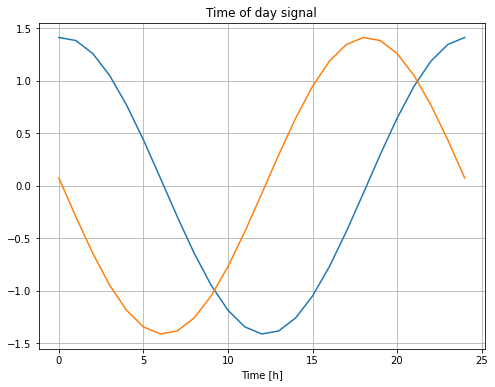

In [ ]:
plt.plot(np.array(ownDf['Day sin'])[:25])
plt.plot(np.array(ownDf['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

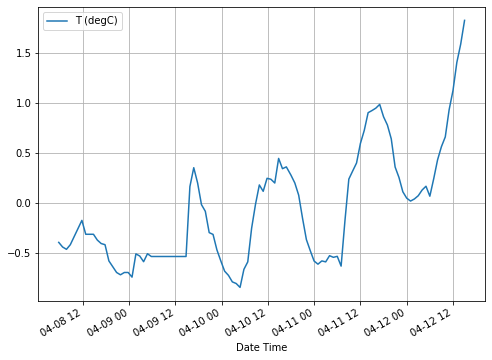

In [ ]:
plot_cols = ['T (degC)']
plot_features = ownDf[plot_cols]
plot_features.index = date_time_pred_data
_ = plot_features.plot(subplots=True)

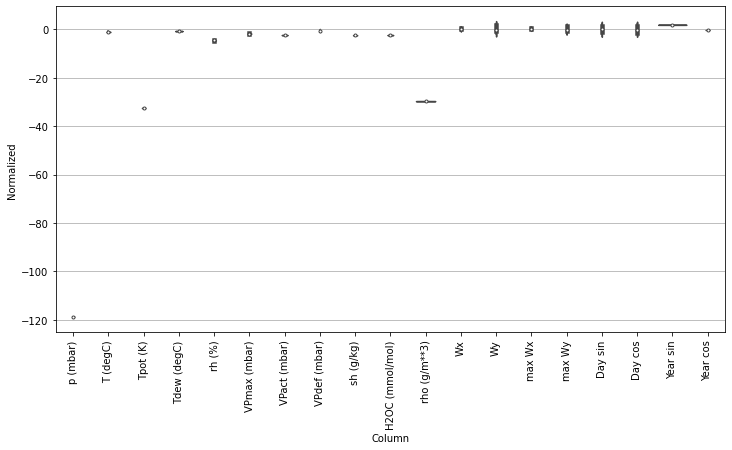

In [ ]:
df_std = (ownDf - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(ownDf.keys(), rotation=90)

## Modell an den Sensordaten testen

In [ ]:
#LABEL_WIDTH_PRED = 5
#CONV_WIDTH = 5

LABEL_WIDTH_PRED = ownDf.shape[0] - CONV_WIDTH
INPUT_WIDTH_PRED = LABEL_WIDTH_PRED + (CONV_WIDTH - 1)

# Fenster mit eigenen Daten erstellen
test_window = WindowGenerator(
    input_width=INPUT_WIDTH_PRED,
    label_width=LABEL_WIDTH_PRED,
    shift=1,
    label_columns=['T (degC)'])

test_window.addDataFrame(ownDf)

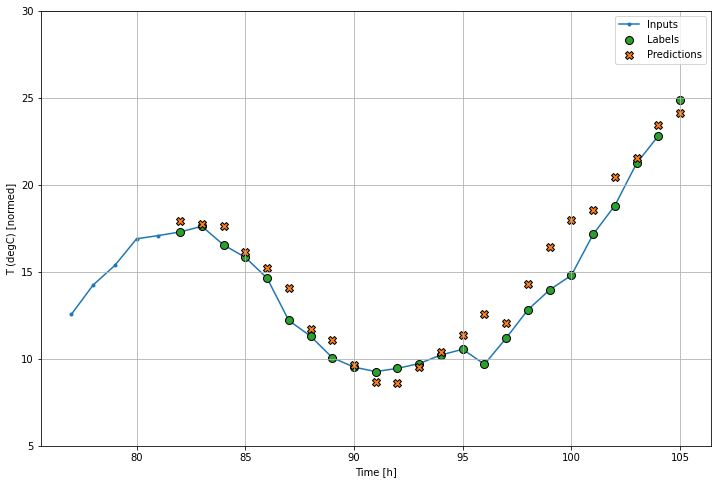

In [ ]:
# Plot und Vorhersagen mithilfe des Models und den Sensordaten des ESP8266
test_window.plot(conv_model, usePredictionData=True, max_subplots=3, denormalise=True, minY=5, maxY=30, lastHours=24)

## Modell an bekannten Trainingsdaten testen

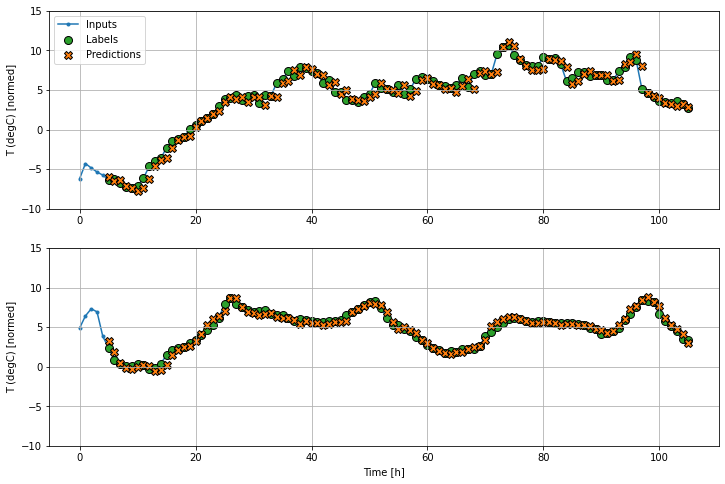

In [ ]:
# selbes Modell, Zufallsdaten aus dem importiereten Datensatz
test_window.plot(conv_model, usePredictionData=False, max_subplots=2, denormalise=True, minY=-10, maxY=15)

## Export des Modells und der Normalisierungsvariablen

### nach Google Drive

In [ ]:
conv_model.save('/content/drive/MyDrive/Projekt III/cnn_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projekt III/cnn_model/assets


### zu loklem Ordner

In [ ]:
conv_model.save('./cnn_model')

### Export normalisierten Variablen
Bitte per Copy & Paste in das andere Notebook einfügen

In [ ]:
train_mean.to_json()

'{"p (mbar)":988.6563426615,"T (degC)":9.1082065915,"Tpot (K)":283.1949577074,"Tdew (degC)":4.5996054053,"rh (%)":75.9060083974,"VPmax (mbar)":13.3550981391,"VPact (mbar)":9.3569596233,"VPdef (mbar)":3.9980559689,"sh (g\\/kg)":5.9135503332,"H2OC (mmol\\/mol)":9.4663709924,"rho (g\\/m**3)":1216.9943574588,"Wx":-0.5941816302,"Wy":-0.3915127138,"max Wx":-0.9621587593,"max Wy":-0.7094007212,"Day sin":-0.0000543023,"Day cos":-0.0000724215,"Year sin":0.0528237873,"Year cos":-0.0162425716}'

In [ ]:
train_std.to_json()

'{"p (mbar)":8.2974656535,"T (degC)":8.6549499378,"Tpot (K)":8.7247458438,"Tdew (degC)":6.9722747663,"rh (%)":16.5553364903,"VPmax (mbar)":7.6947376721,"VPact (mbar)":4.2082596275,"VPdef (mbar)":4.8177405956,"sh (g\\/kg)":2.6712521539,"H2OC (mmol\\/mol)":4.2600545511,"rho (g\\/m**3)":40.9577044444,"Wx":2.0129306023,"Wy":1.5615074615,"max Wx":3.1273220671,"max Wy":2.6196631212,"Day sin":0.7070906334,"Day cos":0.7071373349,"Year sin":0.7006226706,"Year cos":0.7114028534}'

# Alte Routine zum speichern von CSV-Strings

In [ ]:
rawCSV = '''
Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
08.04.2022 05:48:00,1001.06,5.7,278.76481260267553,1.48,74,9.16,6.8,2.3600000000000003,4.222490130291155,6.792799632389667,1247.4028559513542,3.7,10.49,263
08.04.2022 06:48:00,1001.5,5.3,278.3296587950346,2,79.1,8.91,7.06,1.8500000000000005,4.388828183699084,7.049425861208188,1249.6178398957961,3.6,9.36,253.4
08.04.2022 07:48:00,1001.68,5.1,278.115330254125,2,80.1,8.79,7.06,1.7299999999999995,4.3836550499769595,7.048159092724224,1250.7447154169731,3.2,8.02,247.2
08.04.2022 08:48:00,1001.62,5.5,278.5199481873363,2.24,79.5,9.03,7.18,1.8499999999999996,4.470114348309691,7.168387212715401,1248.8090240713286,3.1,7.72,244.4
08.04.2022 09:48:00,1001.12,6.2,279.25983276258575,2.3,76.2,9.48,7.21,2.2700000000000005,4.500407982805999,7.201933834105802,1245.0350443313343,3.1,7.72,245.6
08.04.2022 10:48:00,1000.76,6.9,279.98864755575937,2.06,71,9.95,7.09,2.8599999999999994,4.402510880375006,7.084615692074024,1241.5500875771186,2.7,7.3,245.2
08.04.2022 11:48:00,1000.38,7.6,280.7192395756895,1.92,67.3,10.44,7.02,3.42,4.380196921317901,7.017333413302945,1238.0009929549194,2.6,7.2,245.8
08.04.2022 12:48:00,999.44,6.4,279.59516473755184,1.48,70.5,9.61,6.8,2.8099999999999996,4.227256401651342,6.803810133674857,1242.2621414938656,2.6,5.66,217.2
08.04.2022 13:48:00,998.66,6.4,279.65812712800806,1,68.3,9.61,6.57,3.039999999999999,4.098220092831903,6.578815612921315,1241.389737018272,2.2,5.66,234.9
08.04.2022 14:48:00,998.26,6.4,279.69044011576347,0.82,67.4,9.61,6.49,3.119999999999999,4.045708907968297,6.501312283373069,1240.9320192922983,2.1,5.24,239.8
08.04.2022 15:48:00,997.8,5.9,279.2273029905267,0.72,69.2,9.29,6.44,2.8499999999999988,4.017221936510163,6.454199238324314,1242.6041254943204,2.1,5.14,293.8
08.04.2022 16:48:00,997.54,5.6,278.94807708078315,0.78,71.3,9.1,6.47,2.63,4.055629109670919,6.485955450408004,1243.5883622112954,1.6,4.32,308.6
08.04.2022 17:48:00,997.66,5.5,278.83833260111703,0.8,71.7,9.03,6.48,2.549999999999999,4.046500246676898,6.495198765110358,1244.1911908803522,1.5,4.12,317
08.04.2022 18:48:00,997.46,4.1,277.45342857006017,1.42,82.9,8.19,6.77,1.42,4.244732799338106,6.78723958855493,1250.0729355198077,1.6,4.22,213.5
08.04.2022 19:48:00,997.9,3.6,276.91783798118735,1.64,87,7.91,6.88,1.0300000000000002,4.3006177056758785,6.894478404649765,1252.841409970398,1.5,3.7,250.1
08.04.2022 20:48:00,998.32,3.1,276.38399148200324,1.78,91,7.63,6.95,0.6799999999999997,4.337384890624147,6.9616956486897985,1255.6092674762115,1.5,3.6,282.9
08.04.2022 21:48:00,998.8,2.9,276.14560930434175,1.8,92.3,7.53,6.96,0.5700000000000003,4.339608313576432,6.96836203444133,1257.1214142594085,1.5,4.02,309.1
08.04.2022 22:48:00,999.38,3.1,276.2994154481794,1.8,90.9,7.63,6.96,0.6699999999999999,4.3279984851716975,6.964317877083792,1256.9496046049828,2,4.53,309.2
08.04.2022 23:48:00,1000.38,3.1,276.21973261899996,1.72,90.5,7.63,6.92,0.71,4.304584980825814,6.91737139886843,1258.225191083362,2.1,5.04,308
09.04.2022 00:48:00,1001.7,2.7,275.71490418103105,1.7,93.1,7.42,6.91,0.5099999999999998,4.300689180922044,6.898272936008785,1261.715310776775,2.5,6.61,278.5
09.04.2022 01:48:00,1002.68,4.705502,275.4373138838658,1.38,74.8394,7.32,6.75,0.5700000000000003,4.1882161893447725,6.731958351617665,1263.9522094085632,2.6,7.1,286.2
09.04.2022 02:48:00,1004.26,4.521248,275.21238971290256,1.14,78.87389,7.26,6.64,0.6200000000000001,4.111095124288545,6.611833588911238,1266.4625495359371,2.6,7.2,288
09.04.2022 03:48:00,1005.72,4.029907,275.0971071949824,0.94,82.30106,7.26,6.54,0.7199999999999998,4.050964562993085,6.502803961341129,1268.349977050097,3,7.62,284.8
09.04.2022 04:48:00,1006.88,4.718853,275.0056664710447,0.82,79.40948,7.26,6.49,0.7699999999999996,4.014738178036774,6.445653901160019,1269.8407841282703,3.1,7.72,279.2
09.04.2022 05:48:00,1007.9,4.481194,275.0251470871985,0.88,80.16327,7.32,6.51,0.8100000000000005,4.039353240697003,6.4589741045738664,1270.6470708521626,3.1,7.72,280.4
09.04.2022 06:48:00,1008.9,4.481194,275.6447152898886,0.9,80.16327,7.69,6.52,1.1700000000000008,4.025420959053527,6.462483893349193,1268.6967072773302,3.7,8.85,272.8
09.04.2022 07:48:00,1009.9,4.481194,275.7654034827648,0.98,80.16327,7.8,6.56,1.2400000000000002,4.064608020866949,6.495692642835924,1269.0056368045978,3.6,8.75,274.6
09.04.2022 08:48:00,1010.9,4.481194,276.2848295714783,1.08,80.16327,8.13,6.61,1.5200000000000005,4.081984219548249,6.538727866257791,1267.4988687867165,4,8.75,276.6
09.04.2022 09:48:00,1011.5,4.481194,277.0349210162947,1.1,80.16327,8.6,6.62,1.9799999999999995,4.071510829351706,6.544735541275334,1264.6088974691966,4.5,9.57,279.4
09.04.2022 10:48:00,1012.08,4.481194,277.7863589933261,1.02,80.16327,9.1,6.58,2.5199999999999996,4.0421823624264785,6.501462334993281,1261.7250136873122,4.6,10.19,282.4
09.04.2022 11:48:00,1012.52,4.481194,278.54867396710307,0.84,80.16327,9.61,6.5,3.1099999999999994,3.982660239392489,6.4196262789870815,1258.7066668377188,5,10.7,282.2
09.04.2022 12:48:00,1012.88,4.481194,279.91496037276397,1.02,80.16327,10.58,6.58,4,4.038056242092507,6.496327304320354,1252.8376380887767,5.9,13.06,281.4
09.04.2022 13:48:00,1013.06,4.481194,280.19949530978096,0.52,80.16327,10.8,6.35,4.450000000000001,3.8949467584964994,6.2681381162023975,1251.8322952783133,5.7,12.45,283.6
09.04.2022 14:48:00,1013.1,4.481194,280.1963046802406,0.16,0,10.8,6.18,4.620000000000001,3.794866632446761,6.100088836245188,1251.9576921794614,5.2,11.93,284.8
09.04.2022 15:48:00,1013.34,10.51881,280.3764014054473,0.02,49.84512,10.95,6.12,4.829999999999999,3.772506887972473,6.039433951092427,1251.3813837474029,5.1,11.83,285.8
09.04.2022 16:48:00,1013.64,12.15038,284.18783233661134,-0.16,46.05478,14.17,6.04,8.129999999999999,4.014279096696356,5.958723018034016,1234.6773563633988,4.7,11.83,286.8
09.04.2022 17:48:00,1013.86,10.82856,282.8534632375416,-0.44,52.32166,12.98,5.92,7.0600000000000005,4.177032058719097,5.839070483104176,1240.571154450374,4.6,11.42,285.4
09.04.2022 18:48:00,1014.38,8.959335,280.95009397916783,-0.68,55.42535,11.45,5.82,5.629999999999999,3.9005878200084996,5.737494824424772,1249.6409547249082,4.8,11.52,283.2
09.04.2022 19:48:00,1015.06,8.382545,280.32149195741846,-0.7,61.28328,11.01,5.81,5.2,4.1449447858937285,5.723799578350048,1252.8549637983995,3.8,10.49,283
09.04.2022 20:48:00,1015.76,6.542686,278.43418463387263,-0.62,67.88586,9.71,5.84,3.870000000000001,4.046342412703697,5.74938961959518,1262.0415343010513,3.2,9.05,280.6
09.04.2022 21:48:00,1016.46,6.38781,278.22472253132366,-0.6,64.76234,9.61,5.85,3.76,3.8172490011567213,5.755268284044625,1263.7864917354598,2.7,7.92,276.8
09.04.2022 22:48:00,1017,5.055313,276.8560745009938,-0.52,69.39651,8.76,5.89,2.87,3.726419366750453,5.791543756145526,1270.5841310826677,2.6,6.89,273.6
09.04.2022 23:48:00,1017.74,4.112686,275.8601451704268,-0.58,72.05005,8.2,5.86,2.339999999999999,3.618710793379423,5.757855640929903,1275.9148055036433,2.2,5.86,269.8
10.04.2022 00:48:00,1018.56,3.215458,274.9035959239365,-0.82,74.73716,7.7,5.76,1.9400000000000004,3.521743667674466,5.655042412818096,1281.1637842270175,2.7,6.37,271.2
10.04.2022 01:48:00,1019.1,2.849621,274.49773175733486,-0.8,76.68574,7.5,5.77,1.7300000000000004,3.517831940452858,5.661858502600333,1283.5451318348391,2.2,5.76,264.4
10.04.2022 02:48:00,1019.6,2.288853,273.9012656989744,-1.04,78.73502,7.21,5.67,1.54,3.470378910697167,5.561004315417811,1286.8263699078827,2.1,4.83,260.6
10.04.2022 03:48:00,1019.86,2.147327,273.74039999704,-1.02,77.47311,7.13,5.67,1.46,3.375814468110508,5.5595866099268525,1287.8900804317,2.1,4.22,253.6
10.04.2022 04:48:00,1019.98,1.810864,273.3965627731636,-0.92,78.5565,6.96,5.72,1.2400000000000002,3.340943515245767,5.607953097119552,1289.6450386322622,2.1,3.7,244
10.04.2022 05:48:00,1020.24,3.370335,274.92695219748606,-0.9,73.36996,7.78,5.72,2.0600000000000005,3.487414225201826,5.606523955147808,1282.584868087597,2.1,3.6,238.8
10.04.2022 06:48:00,1020.1,4.016556,275.580356127997,-1.7,71.13451,8.14,5.4,2.74,3.538208172129634,5.293598666797373,1279.3794878846004,2.6,4.73,224.6
10.04.2022 07:48:00,1020.76,6.924545,278.4197636068745,-1.44,62.5742,9.97,5.5,4.470000000000001,3.8103060098492993,5.3881421685802735,1266.7059397991206,2.2,4.63,221.4
10.04.2022 08:48:00,1021.3,8.975357,280.41568407128915,-0.92,56.26154,11.46,5.72,5.740000000000001,3.936126668597181,5.60070498384412,1258.0673214940894,2.1,4.63,232.2
10.04.2022 09:48:00,1021.72,10.66034,282.0570085442772,-0.48,53.67056,12.83,5.9,6.93,4.2026888097174355,5.774576204831069,1250.9102995348958,2.1,5.04,249.4
10.04.2022 10:48:00,1021.88,10.11024,281.4975943834485,-0.24,54.58305,12.37,6.01,6.359999999999999,4.12004717164711,5.881316788664031,1253.5986790820264,2.5,5.56,259.4
10.04.2022 11:48:00,1022.06,11.23446,282.60046335018365,-0.36,45.89761,13.33,5.95,7.38,3.7317813160814723,5.821576032718236,1249.1569608883544,2.6,6.07,269.8
10.04.2022 12:48:00,1022.02,11.15168,282.5213915103091,-0.24,46.96117,13.26,6.01,7.25,3.7985073035543757,5.880511144595996,1249.421222390147,3.1,7.82,290.4
10.04.2022 13:48:00,1021.84,10.82856,282.214630452624,-0.54,45.40475,12.98,5.88,7.1000000000000005,3.5952532299165045,5.754325530415721,1250.776703828467,3.1,7.72,295
10.04.2022 14:48:00,1021.72,12.95148,284.3339942755093,-0.68,38.73808,14.93,5.82,9.11,3.5284568943313985,5.696276866460479,1241.400225346538,3.1,7.72,296.8
10.04.2022 15:48:00,1021.46,12.06493,283.4737272410994,-0.62,40.8072,14.09,5.84,8.25,3.508649774461023,5.717306600356353,1244.9570111002079,3.1,7.3,303.4
10.04.2022 16:48:00,1021.24,12.21981,283.6452816977139,-0.76,38.25437,14.23,5.78,8.45,3.322175857312182,5.659786142336767,1244.1540392069608,2.7,6.79,306.6
10.04.2022 18:00:00,1020.6,11.50416,282.98511379670936,-2.1,39.63989,13.57,5.24,8.33,3.284818400999225,5.134234763864393,1246.528557350158,2.6,6.17,309
10.04.2022 19:00:00,1020.5,10.82856,282.3214532076251,-1.7,40.92165,12.98,5.4,7.58,3.2438343246024433,5.291523762861343,1249.4027455701753,2.1,5.14,314
10.04.2022 20:00:00,1020.5,9.776455,281.27548758075875,-1.4,43.66827,12.1,5.52,6.58,3.2268421200986954,5.409113179813817,1254.0617647419363,1.5,4.12,317
10.04.2022 21:00:00,1020.8,7.781719,279.2687170350204,-1.3,55.42992,10.57,5.56,5.010000000000001,3.5777531436394163,5.446708463949843,1263.0685775981428,1.5,3.6,162
10.04.2022 22:00:00,1020.9,5.939194,277.4292612808588,-0.9,63.71862,9.31,5.72,3.5900000000000007,3.622232698876987,5.602899402488001,1271.497510266063,1.5,3.09,141
10.04.2022 23:00:00,1021,4.985886,276.4738132521391,-0.8,66.65446,8.72,5.77,2.950000000000001,3.5484937585286267,5.651322233104799,1276.037589033737,1.5,3.09,151
11.04.2022 00:00:00,1021.4,4.085983,275.548158760011,-1.8,71.37713,8.18,5.36,2.8199999999999994,3.5632353024680223,5.247699236342275,1280.6696744431572,2.1,3.6,163
11.04.2022 01:00:00,1021.3,3.818951,275.2905257685589,-1.7,72.23315,8.03,5.4,2.629999999999999,3.5401417885215136,5.287378830901792,1281.796843577266,2.1,3.6,153
11.04.2022 02:00:00,1020.9,4.099335,275.6003451701514,-1.5,69.70321,8.19,5.48,2.709999999999999,3.4854669261023874,5.367812714271722,1280.0414793410132,2.1,3.6,144
11.04.2022 03:00:00,1020.7,4.016556,275.5336270187443,-1.3,73.73617,8.14,5.56,2.580000000000001,3.6657414643847464,5.447242088762613,1280.0329895565487,2.1,3.6,133
11.04.2022 04:00:00,1020.5,4.550621,276.080148013216,-1.1,70.74235,8.46,5.64,2.820000000000001,3.6558569988425305,5.526702596766291,1277.3285947037089,2.1,4.12,125
11.04.2022 05:00:00,1020.3,4.409096,275.9550472867448,-1,74.31144,8.37,5.68,2.6899999999999995,3.800525999321121,5.566990100950701,1277.6173492803086,2.1,4.12,114
11.04.2022 06:00:00,1019.7,4.494545,276.08683581463595,-1.2,74.37553,8.42,5.6,2.8200000000000003,3.8288439097505247,5.491811317054036,1276.451139776182,2.1,3.09,100
11.04.2022 07:00:00,1019.8,3.650723,275.23996373773235,-0.9,78.85558,7.94,5.72,2.2200000000000006,3.827679221979555,5.608942929986272,1280.468842956788,2.1,3.6,105
11.04.2022 08:00:00,1019.7,7.594795,279.16969203547154,-0.6,64.06805,10.44,5.85,4.59,4.090122310525514,5.736981465136805,1262.1554014601759,2.6,4.12,109
11.04.2022 09:00:00,1019.5,11.16503,282.7358906892621,0,50.66758,13.27,6.11,7.159999999999999,4.112315319295538,5.993133889161354,1246.0449009264057,3.1,5.14,113
11.04.2022 10:00:00,1019.2,11.86732,283.45833828585705,0.5,49.26223,13.9,6.34,7.5600000000000005,4.18950126893044,6.220565149136577,1242.5507115581668,3.6,6.69,123
11.04.2022 11:00:00,1018.8,12.55627,284.17568931484817,0.8,45.83963,14.55,6.48,8.07,4.08206343099296,6.360424028268551,1239.1486580117387,4.6,7.72,126
11.04.2022 12:00:00,1018.4,14.24392,285.8866740947252,-0.3,38.38712,16.24,5.98,10.259999999999998,3.8163464198312655,5.871956009426552,1231.5868035397318,5.7,9.77,123
11.04.2022 13:00:00,1017.7,15.37079,287.06455364432736,-0.2,37.83627,17.47,6.02,11.45,4.0498370591553075,5.915299204087648,1225.7598525755059,5.7,9.77,124
11.04.2022 14:00:00,1016.9,16.90089,288.65238875739817,0,35.07896,19.26,6.11,13.150000000000002,4.142908598244776,6.008457075425312,1218.2664133646426,5.7,9.77,123
11.04.2022 15:00:00,1016.1,17.08514,288.90131629635357,0,32.3888,19.48,6.11,13.370000000000001,3.871296665810859,6.013187678378112,1216.735559152599,5.7,9.77,125
11.04.2022 16:00:00,1015.4,17.29343,289.1661150329394,0,33.03883,19.74,6.11,13.629999999999999,4.004782089524809,6.01733307071105,1214.9270342350007,5.7,9.77,123
11.04.2022 17:00:00,1014.6,17.61921,289.55627397423007,0,32.21332,20.15,6.11,14.04,3.988923848348469,6.0220776660753,1212.6213513314692,5.1,9.26,123
11.04.2022 18:00:00,1014.1,16.54841,288.53095543515207,-0.2,33.55459,18.83,6.02,12.809999999999999,3.8844903105718798,5.936298195444236,1216.5807469619024,5.7,9.77,126
11.04.2022 19:00:00,1013.9,15.83276,287.8345620393519,0.3,36.96193,17.99,6.25,11.739999999999998,4.089377418421099,6.164316007495809,1219.2015572410014,4.6,9.26,126
11.04.2022 20:00:00,1013.7,14.63913,286.66198374518757,0.8,39.73755,16.66,6.48,10.18,4.072195581304489,6.3924237940219,1224.029554959012,4.1,7.72,122
11.04.2022 21:00:00,1013.9,12.20646,284.22267020081,1,44.45258,14.22,6.57,7.65,3.8870012052965146,6.479928987079594,1234.846631273,3.6,7.2,122
11.04.2022 22:00:00,1014.1,11.30388,283.3075603474527,1.3,50.45853,13.39,6.71,6.680000000000001,4.154493133710324,6.616704467015087,1238.8082731307309,4.1,6.69,118
11.04.2022 23:00:00,1014.2,10.07019,282.0708204568395,1.4,54.43961,12.34,6.76,5.58,4.130321445140043,6.665352001577598,1244.3453713611793,4.1,7.2,119
12.04.2022 00:00:00,1014.1,9.520103,281.53097178387293,0.3,57.13741,11.89,6.25,5.640000000000001,4.177450602075369,6.163100285967853,1246.6083677088639,3.1,4.63,117
12.04.2022 01:00:00,1013.7,9.269093,281.3129788706634,0.7,59.20501,11.69,6.43,5.26,4.257693051669277,6.3430995363519775,1247.1635208631894,3.1,5.66,120
12.04.2022 02:00:00,1013.1,9.450676,281.5419204100905,0.9,60.17243,11.84,6.52,5.32,4.3857257025053435,6.435692429177771,1245.5277873654159,3.6,6.17,123
12.04.2022 03:00:00,1012.9,9.73106,281.8373012571238,1.1,56.99092,12.06,6.62,5.44,4.231460821099851,6.535689604107019,1244.1639496780224,3.6,6.17,115
12.04.2022 04:00:00,1012.7,10.2224,282.3429075989177,1.3,55.19646,12.46,6.71,5.750000000000001,4.234998967161469,6.62585168361805,1241.7587900949018,3.6,6.17,118
12.04.2022 05:00:00,1012.6,10.54818,282.67555444886784,1.5,54.29465,12.74,6.81,5.930000000000001,4.25990535815222,6.725261702547896,1240.1916351244886,3.6,6.17,114
12.04.2022 06:00:00,1012,9.688335,281.86698638055327,1.3,61.63577,12.03,6.71,5.319999999999999,4.569944844648076,6.630434782608695,1242.9911915559762,4.1,7.72,113
12.04.2022 07:00:00,1012.2,11.19173,283.34906964589663,1.7,58.57023,13.3,6.91,6.390000000000001,4.800826589739996,6.826714088124876,1236.4904754044735,4.1,7.72,118
12.04.2022 08:00:00,1012.1,12.8233,284.9830638357379,2.2,50.67674,14.81,7.16,7.65,4.625385263639146,7.074399762869281,1229.445144336582,4.1,7.2,120
12.04.2022 09:00:00,1012,13.96353,286.127499124836,2.9,47.09697,15.95,7.53,8.419999999999998,4.630010428710133,7.440711462450593,1224.4381557142171,4.1,7.2,127
12.04.2022 10:00:00,1011.9,14.80735,286.97659975647645,3.5,46.42863,16.84,7.85,8.99,4.8200239232425455,7.757683565569721,1220.5889087765527,4.6,8.23,134
12.04.2022 11:00:00,1011.7,17.15458,289.33232894469813,4.1,41.76852,19.57,8.19,11.38,5.0408654932488615,8.095285163586041,1210.3186863666538,5.1,8.75,138
12.04.2022 12:00:00,1011.3,18.81285,291.01823356267175,3.6,39.68261,21.72,7.91,13.809999999999999,5.318264999116898,7.821615742114111,1202.7664376234216,5.7,10.29,125
12.04.2022 13:00:00,1010.9,21.24284,293.4738431407667,4.2,35.54742,25.25,8.25,17,5.541277107019789,8.161044613710555,1192.2056410014352,6.2,9.77,131
12.04.2022 14:00:00,1010.5,22.82101,295.0807648351158,4.6,33.6141,27.8,8.48,19.32,5.772172413307419,8.39188520534389,1185.2136044603733,5.7,10.29,137
12.04.2022 15:00:00,1010,24.8745,297.1704923667935,5,31.63348,31.46,8.72,22.740000000000002,6.151675891312226,8.633663366336634,1176.1943381005037,5.7,10.29,141
'''

In [ ]:
text_file = open("/content/drive/MyDrive/Projekt III/owndata.csv", "w")
n = text_file.write(rawCSV)
text_file.close()